In [126]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Estimator

In [170]:
n_qubits=6
j_coupling=0.5
g=1.5
h_coupling=j_coupling*g
n_rep_VQEansatz=1

Hamiltonian =  SparsePauliOp(['XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX', 'ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ'],
              coeffs=[ 0.75+0.j, -0.75+0.j, -0.75+0.j, -0.75+0.j, -0.75+0.j, -0.75+0.j,
 -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j])
ground state energy = (-4.923785735577327+0j)


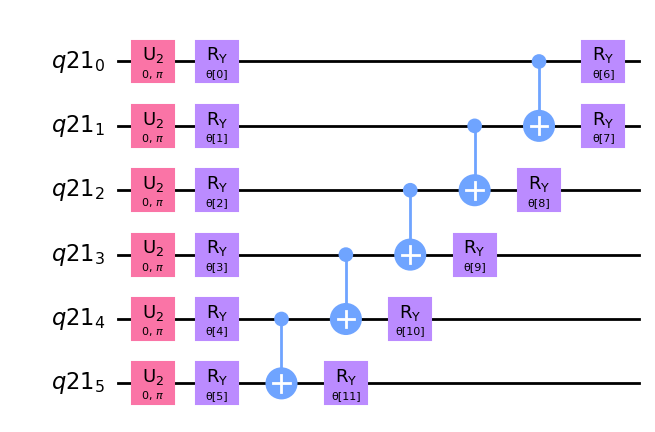

In [171]:
qr = QuantumRegister(n_qubits)
qc = QuantumCircuit(qr)
ansatz =  RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz)
qc.h(qr)
qc.compose(ansatz, inplace=True)  

observable = SparsePauliOp.from_list([("X"+"I"*(n_qubits-1) , h_coupling )])

for i in np.arange(1,n_qubits,1):
    observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-1-i) , -h_coupling )])
    
for i in range(n_qubits-1):
    observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(n_qubits-2-i) ,- j_coupling)]))

    
qnn=EstimatorQNN(
    estimator=Estimator(options={"shots":1e7}),
    circuit=qc,
    weight_params=ansatz.parameters,
    observables=observable
    )
print("Hamiltonian = ",observable)

eigenValues=np.linalg.eig(observable.to_matrix())[0]
eigenValues.sort()

groundEnergy=eigenValues[0]
print("ground state energy =", groundEnergy)
qc.decompose().draw('mpl')

In [172]:
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x,label='ground state energy')
    #plt.show()
def computeMag(x):
    x2=x**2
    return x2.sum()

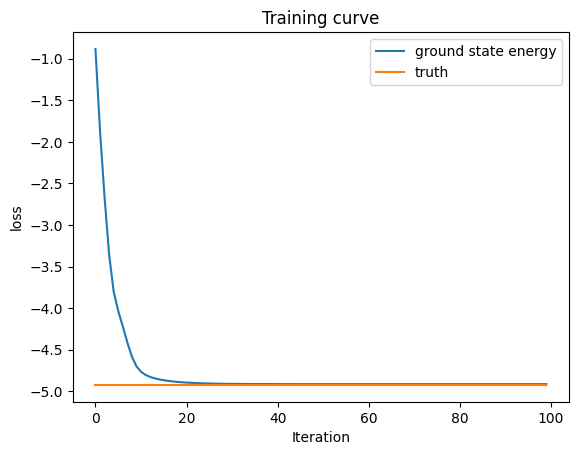

In [174]:
init_weights=np.random.rand(qnn.num_weights)*2*np.pi
weights=init_weights

nSteps=100
learning_rate=5e-1
loss=[]
gradMag=[]
for i in range(nSteps):
    vev=qnn.forward([], weights)[0][0]
    input_grad, weight_grad=qnn.backward([],weights)
    grad=weight_grad[0,0,:]
    weights=weights-learning_rate*grad

    loss.append(vev)
    gradMag.append(computeMag(grad))
    
    if i%1==0:
        
        clear_output(wait=True)
        plt.figure(1)
        callback_graph(loss)
        plt.plot(range(len(loss)),groundEnergy*np.ones(len(loss)),label='truth')
        plt.legend()
        #plt.yscale('log')
        plt.show()